In [55]:

# NOTE: .cdsapirc needs to be set up in your home repo
# Go to https://cds.climate.copernicus.eu/
# Click on profile to get API key

from pathlib import Path
import cdsapi
import torch
import xarray as xr
from aurora import Batch, Metadata, Aurora, rollout
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
from pyproj import Proj
import numpy as np


# Data will be downloaded here.
download_path = Path("../downloads/")
print(download_path)

# Rollout steps. 1 step = 6 hours
STEPS = 28

../downloads


In [26]:
# Download the static variables.
c = cdsapi.Client()

# Static variables only need one time step
# Surface & Atmospheric Variables must be at every time step
# NOTE: in order to make a prediction, Aurora needs [t-1, t] to predict [t+1]


if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2023-01-01-surface-level.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "mean_sea_level_pressure",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-surface-level.nc"),
    )
print("Surface-level variables downloaded!")

# Download the atmospheric variables.
if not (download_path / "2023-01-01-atmospheric.nc").exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "temperature",
                "u_component_of_wind",
                "v_component_of_wind",
                "specific_humidity",
                "geopotential",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-atmospheric.nc"),
    )
print("Atmospheric variables downloaded!")

2024-11-01 10:08:58,697 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-01 10:08:58,698 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informative page](https://confluence.ecmwf.int/x/uINmFw) for guidance.
2024-11-01 10:08:58,700 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-01 10:08:58,700 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-01 10:08:58,700 WARNING [2024-06-16T

Static variables downloaded!
Surface-level variables downloaded!
Atmospheric variables downloaded!


In [27]:
# Prepare batches of data

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / "2023-01-01-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / "2023-01-01-atmospheric.nc", engine="netcdf4")

i = 1  # Select this time index in the downloaded data.

batch = Batch(
    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[[i - 1, i]][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[[i - 1, i]][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[[i - 1, i]][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[[i - 1, i]][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[[i - 1, i]][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[[i - 1, i]][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[[i - 1, i]][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[[i - 1, i]][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[[i - 1, i]][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

In [28]:
# Instantiate model - requires downloading model weights

model = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

model.eval()
model = model.to("cuda")

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=STEPS)]

model = model.to("cpu")

In [29]:
# Access the projection information
static_vars_ds.attrs

# Get the coordinates
lat = static_vars_ds.coords['latitude']
lon = static_vars_ds.coords['longitude']

# Infer the projection
projection = Proj('+proj=latlong')

# Print the projection information
print(projection)

proj=longlat datum=WGS84 no_defs ellps=WGS84 towgs84=0,0,0


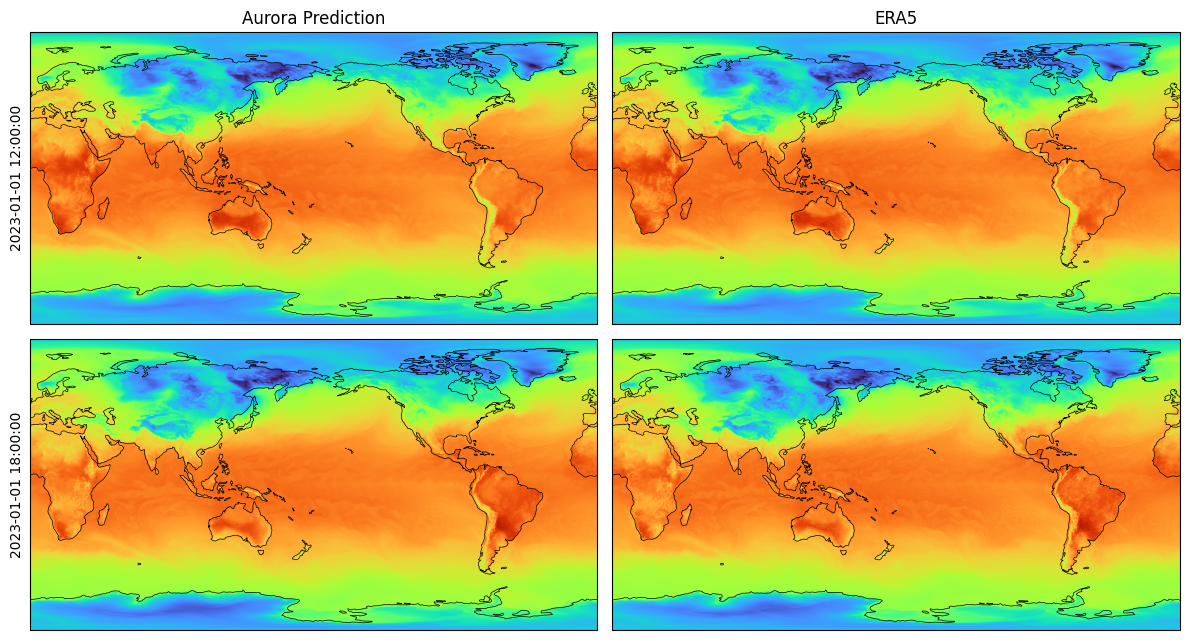

In [30]:
# Plot model outputs

crs = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(2, 2, figsize=(12, 6.5), subplot_kw={'projection': crs})

lon = np.arange(-180, 180, 0.25)
lat = np.arange(-90, 90, 0.25)
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

for i in range(ax.shape[0]):
    pred = preds[i]

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50, cmap='turbo', transform=crs, extent=extent)
    # Add coastlines with cartopy
    ax[i, 0].coastlines(linewidth=0.5)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_aspect('auto')

    ax[i, 1].set_global()
    ax[i, 1].imshow(surf_vars_ds["t2m"][2 + i].values - 273.15, vmin=-50, vmax=50, cmap='turbo', transform=crs, extent=extent)
    ax[i, 1].coastlines(linewidth=0.5)
    if i == 0:
        ax[i, 1].set_title("ERA5")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    ax[i, 1].set_aspect('auto')



plt.tight_layout()
plt.savefig("ERA5_Comparison.png")
plt.show()

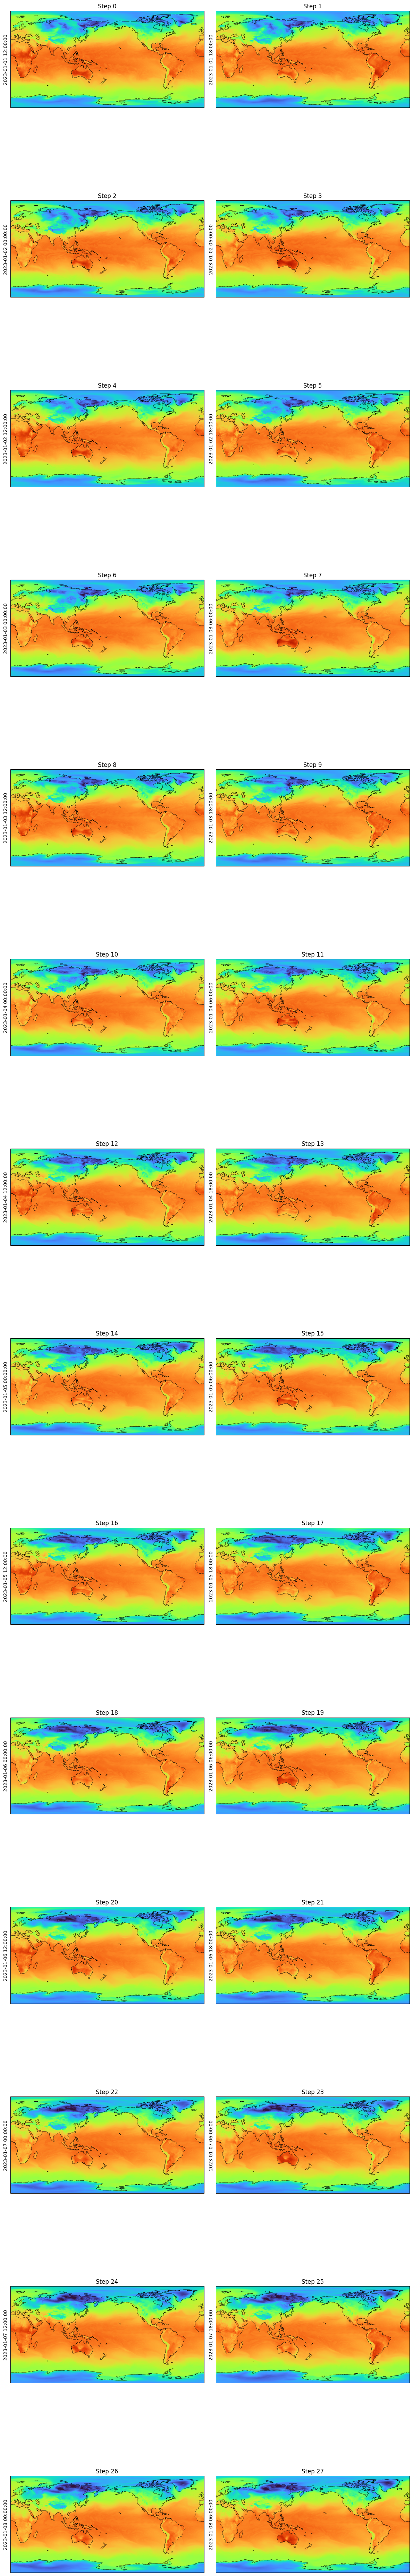

In [49]:
# Plot rollout outputs

crs = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(STEPS//2, 2, figsize=(12, 78), subplot_kw={'projection': crs})

lon = np.arange(-180, 180, 0.25)
lat = np.arange(-90, 90, 0.25)
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

for i in range(STEPS):
    pred = preds[i]

    ax[i//2, i%2].set_aspect('auto')
    ax[i//2, i%2].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50, cmap='turbo', transform=crs, extent=extent)
    ax[i//2, i%2].coastlines(linewidth=0.5)
    ax[i//2, i%2].set_ylabel(str(pred.metadata.time[0]))
    ax[i//2, i%2].set_title(f"Step {i}")
    ax[i//2, i%2].set_xticks([])
    ax[i//2, i%2].set_yticks([])


plt.tight_layout()
plt.savefig("AutoRegOutput.png")
plt.show()

In [64]:
import imageio.v3 as iio
import os

def create_gif_from_plots(output_path="aurora_animation.gif", fps=5):
    # Create and save individual plot images
    images = []
    crs = ccrs.PlateCarree(central_longitude=180)

    lon = np.arange(-180, 180, 0.25)
    lat = np.arange(-90, 90, 0.25)
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]   

    for i in range(STEPS):
        # Your plotting code here   
        pred = preds[i]  

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1, projection=crs)
        ax.set_aspect('auto')
        ax.imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50, cmap='turbo', transform=crs, extent=extent)
        ax.coastlines(linewidth=0.7)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='black')
        ax.set_ylabel(str(pred.metadata.time[0]))
        ax.set_title(f"Step {i}")
        ax.set_xticks([])
        ax.set_yticks([])

        # ... your plot commands ...
        
        # Save plot to memory
        plt.savefig(f"temp_{i}.jpg", bbox_inches='tight')
        # Clear the current figure
        plt.close()
        
        # Read the saved image
        images.append(iio.imread(f"temp_{i}.jpg"))
    
    # Create GIF
    iio.imwrite(output_path, images, loop=0, fps=5)

    # Delete temporary images
    for i in range(STEPS):
        os.remove(f"temp_{i}.jpg")

create_gif_from_plots(fps=8)